# Import the dataset

In [1]:
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 960.9 kB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [kagglehub]


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Path to dataset files:", path)

/home/wandy/improc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 736M/736M [08:18<00:00, 1.55MB/s] 

Extracting files...


Path to dataset files: /home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1


# Visualize the dataset
Samples two random images per class

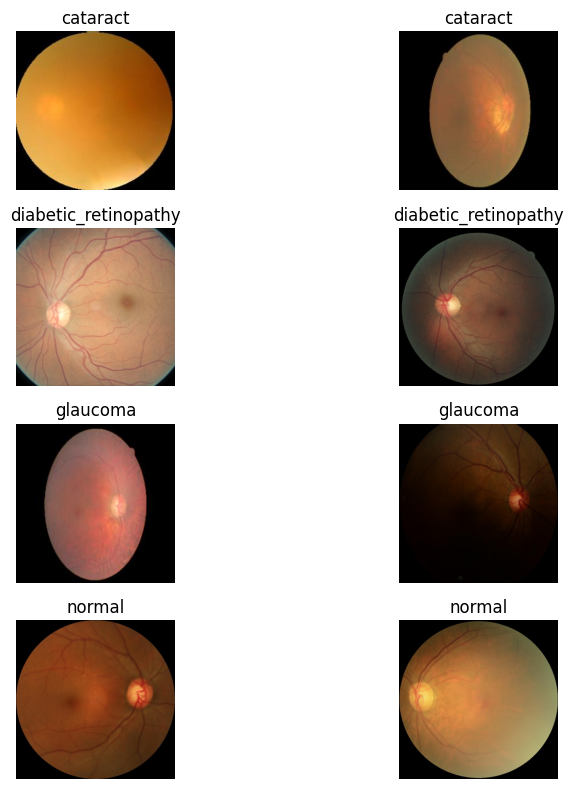

In [3]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Folder names (classes)
CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Dictionary to store sampled file paths
sampled_images = {}

# Randomly pick 2 images per class
for cls in CLASSES:
    folder_path = os.path.join(path,"dataset", cls)
    all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sampled = random.sample(all_images, 2)
    sampled_images[cls] = [os.path.join(folder_path, img) for img in sampled]

# Display the sampled images
plt.figure(figsize=(10, 8))

idx = 1
for cls, img_paths in sampled_images.items():
    for img_path in img_paths:
        plt.subplot(4, 2, idx)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()


In [5]:
import os
import shutil
import random

SOURCE = "/home/wandy/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1/dataset"
DEST = "/home/wandy/improc/UAS/dataset_split"

CLASSES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Create destination folders
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        os.makedirs(os.path.join(DEST, split, cls), exist_ok=True)

# Perform the split
for cls in CLASSES:
    src_folder = os.path.join(SOURCE, cls)
    images = os.listdir(src_folder)
    random.shuffle(images)

    n = len(images)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)  # 70% + 15% = 85%

    train_files = images[:train_end]
    val_files = images[train_end:val_end]
    test_files = images[val_end:]

    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "train", cls))

    for f in val_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "val", cls))

    for f in test_files:
        shutil.copy(os.path.join(src_folder, f), os.path.join(DEST, "test", cls))

print("Dataset successfully split into train, val, test!")


Dataset successfully split into train, val, test!


In [7]:
DEST = "/home/wandy/improc/UAS/dataset_split"

splits = ["train", "val", "test"]

print("\nSplit Dataset Counts:")
split_totals = {"train": 0, "val": 0, "test": 0}

for split in splits:
    print(f"\n[{split.upper()}]")
    for cls in CLASSES:
        folder = os.path.join(DEST, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
        split_totals[split] += count
        print(f"{cls}: {count}")

print("\nTOTALS:")
for split in splits:
    print(f"{split}: {split_totals[split]}")

print(f"\nGRAND TOTAL (train + val + test): {sum(split_totals.values())}")



Split Dataset Counts:

[TRAIN]
cataract: 726
diabetic_retinopathy: 768
glaucoma: 704
normal: 751

[VAL]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 151
normal: 161

[TEST]
cataract: 156
diabetic_retinopathy: 165
glaucoma: 152
normal: 162

TOTALS:
train: 2949
val: 633
test: 635

GRAND TOTAL (train + val + test): 4217


In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


2025-12-06 23:49:25.676377: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 23:49:26.247757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 23:49:28.258539: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [9]:
DATASET_DIR = "/home/wandy/improc/UAS/dataset_split/"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [11]:
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)


Found 2949 images belonging to 4 classes.


In [12]:
val_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="sparse"
)


Found 633 images belonging to 4 classes.


In [13]:
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="sparse"
)


Found 635 images belonging to 4 classes.


In [14]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze layers


I0000 00:00:1765039769.811393    5534 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 18s 1us/step


In [15]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)  # 4 classes

model = models.Model(inputs, outputs)


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]


In [23]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 29s 301ms/step - accuracy: 0.2540 - loss: 1.4059 - val_accuracy: 0.2607 - val_loss: 1.3860 - learning_rate: 1.0000e-06
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.2458 - loss: 1.4083 - val_accuracy: 0.2923 - val_loss: 1.3866 - learning_rate: 1.0000e-06
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 271ms/step - accuracy: 0.2614 - loss: 1.3980 - val_accuracy: 0.2464 - val_loss: 1.3885 - learning_rate: 1.0000e-06
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - accuracy: 0.2604 - loss: 1.4059 - val_accuracy: 0.2433 - val_loss: 1.3908 - learning_rate: 1.0000e-06


In [ ]:
base_model.trainable = True

# Unfreeze last 30 layers only
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 62s 464ms/step - accuracy: 0.2591 - loss: 1.4065 - val_accuracy: 0.2780 - val_loss: 1.3867 - learning_rate: 1.0000e-05
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.2665 - loss: 1.3989 - val_accuracy: 0.2227 - val_loss: 1.3886 - learning_rate: 1.0000e-05
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - accuracy: 0.2604 - loss: 1.4012 - val_accuracy: 0.2417 - val_loss: 1.3925 - learning_rate: 2.0000e-06
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.2553 - loss: 1.4058 - val_accuracy: 0.2401 - val_loss: 1.3944 - learning_rate: 2.0000e-06


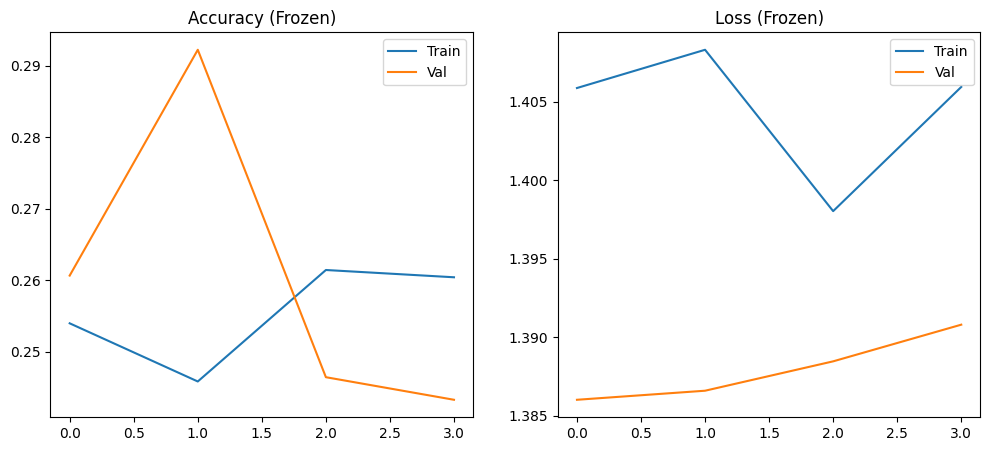

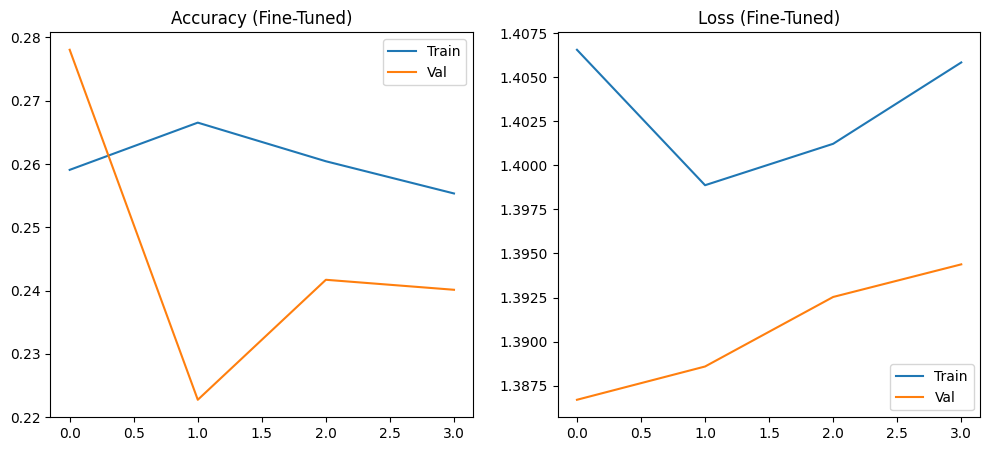

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy (Frozen)")
plt.legend(["Train", "Val"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss (Frozen)")
plt.legend(["Train", "Val"])

plt.show()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.title("Accuracy (Fine-Tuned)")
plt.legend(["Train", "Val"])

plt.subplot(1,2,2)
plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.title("Loss (Fine-Tuned)")
plt.legend(["Train", "Val"])

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.2803 - loss: 1.3867
Test Accuracy: 0.28031495213508606
